In [1]:
# Use Python 3.6, networkx 1.11
# Necessary...
import csv # to read CSV file
import networkx as nx # to make and analyze networks/graphs
import unicodedata # to compare strings while ignoring case
import matplotlib.pyplot as plt # to draw figures
from matplotlib.pyplot import figure # to draw figures
from tabulate import tabulate # to display markdown-compatible tables
import operator # to make sorting easier, using .itemgetter

# Function to ignore case, when searching for occurrences of definiendum and short definiendum in definiens.
def normalize_caseless(text):
    return unicodedata.normalize("NFKD", text.casefold())

/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Set the name of the project, to use as prefix on names of all output files.
analysis_project_name = "UN_GWHT_TDN"
# Point to CSV file that holds raw definitions. 1st column is the definiendum, 2nd the short definiendum, and 3rd the definiens.
analysis_project_data_file = "ilang_UN_GWHT_terminology_raw - Sheet1.csv"

In [22]:
# Get raw definitions from a CSV file
# Create empty raw_definitions, to hold definiendum, short definiendum (abbreviation of definiens), and definiens.
raw_definitions = []
# Fill raw_definitions as a list of triples, where a triple includes the definiendum, short definiendum, and definiens.
with open(analysis_project_data_file) as raw_definitions_file:
    raw_definitions_csv = csv.reader(raw_definitions_file, delimiter = ',')
    for row in raw_definitions_csv:
        raw_definitions.append({'definiendum':row[0], 'short definiendum':row[1], 'definiens':row[2]})

In [4]:
# Language as Network
# Create an empry term dependencies network, to hold dependencies of definitions on terms.
term_dependency_network = []
# Make the term dependency network as follows, and fill it into term_dependency_network:
# If a definiendum or short definendum A appears in a definiens of B, then definiendum B depends on definiendum A.
for i in raw_definitions:
    for j in raw_definitions:
        if (normalize_caseless(i['definiendum']) in normalize_caseless(j['definiens'])) or (normalize_caseless(i['short definiendum']) in normalize_caseless(j['definiens'])):
            term_dependency_network.append({'definiendum':j['definiendum'], 'depends on':i['definiendum']})

In [5]:
# Create a networkx graph to hold the term dependency network
tdn_graph = nx.DiGraph()
for i in term_dependency_network:
    tdn_graph.add_edge(i['definiendum'], i['depends on'], label = 'depends')

In [6]:
# Evaluate Term Importance
# Compute and show term importance, as count of edges entering that node (in degree)
nx.set_node_attributes(tdn_graph, values = tdn_graph.in_degree(), name = 'In degree')
in_degrees_data = list(nx.get_node_attributes(tdn_graph, 'In degree').items())
in_degrees_data.sort(key = operator.itemgetter(1), reverse=True)

# Print output to text file.
output_file_name = "%s_Term_Importance.txt" % analysis_project_name
with open(output_file_name, "w") as text_file:
    print(tabulate(in_degrees_data, headers = ['Term', 'Used in'], tablefmt="pipe"), file=text_file)

In [7]:
# Evaluate Term Sensitivity to Change
# Compute and show term sensitivity to change, as count of edges exiting that node (out degree)
nx.set_node_attributes(tdn_graph, values = tdn_graph.out_degree(), name = 'Out degree')
out_degrees_data = list(nx.get_node_attributes(tdn_graph, 'Out degree').items())
out_degrees_data.sort(key = operator.itemgetter(1), reverse=True)

# Print output to text file.
output_file_name = "%s_Term_Change_Sensitivity.txt" % analysis_project_name
with open(output_file_name, "w") as text_file:
    print(tabulate(out_degrees_data, headers = ['Term', 'Uses'], tablefmt="pipe"), file=text_file)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/home/nbuser/ana

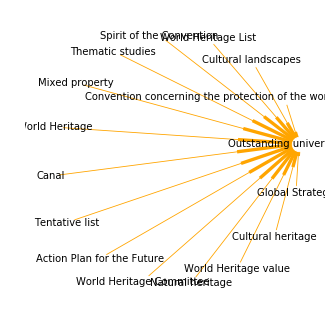

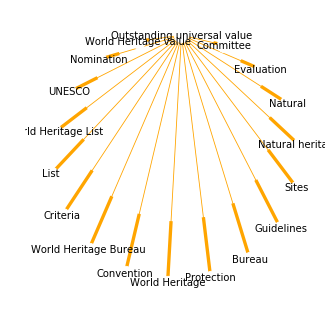

In [8]:
# Importance and Change Sensitivity Together
# Pick a single term to evaluate importance and change sensitivity of.
given_term = 'Outstanding universal value'

# STIN: Single Term Importance Network
# Build STIN, Single Term Importance Network, that includes only all edges which end in the given term.
stin = nx.DiGraph()
for i in tdn_graph.edges():
    if given_term == i[1]:
        stin.add_edge(i[0], i[1])

# Display STIN as markdown-compatible table
from tabulate import tabulate
stin_rows = []
for i in stin.edges():
    stin_rows.append((i[0], i[1]))

# Print output to text file.
output_file_name = "%s_%s_STIN.txt" % (analysis_project_name,given_term.replace(" ","_"))
with open(output_file_name, "w") as text_file:
    print(given_term, "is used in", len(stin_rows), "terms.", file=text_file)
    print(tabulate(stin_rows, headers = ['Term', 'Uses'], tablefmt="pipe"), file=text_file)

# Draw STIN and save as PNG image
figure(num=None, figsize=(5, 5), dpi=60, facecolor='w', edgecolor='g')
pos = nx.spring_layout(stin, k=20)
nx.draw(stin, pos, arrows=True, with_labels=True, node_color='#FFFFFF', edge_color='#FFA500')
image_file_name = "%s_STIN.png" % given_term.replace(" ","_")
plt.savefig(image_file_name)

# TCSN: Term Change Sensitivity Network
# Build TCSN, Term Change Sensitivity Network, that includes only all edges which start in the given term.
tcsn = nx.DiGraph()
for i in tdn_graph.edges():
    if given_term == i[0]:
        tcsn.add_edge(i[0], i[1])

# Display TCSN as markdown-compatible table
from tabulate import tabulate
tcsn_rows = []
for i in tcsn.edges():
    tcsn_rows.append((i[0], i[1]))

# Print output to text file.
output_file_name = "%s_%s_TCSN.txt" % (analysis_project_name,given_term.replace(" ","_"))
with open(output_file_name, "w") as text_file:
    print(given_term, "uses", len(tcsn_rows), "terms.", file=text_file)
    print(tabulate(tcsn_rows, headers = ['Term', 'Uses'], tablefmt="pipe"), file=text_file)

# Draw TCSN and save as PNG image
figure(num=None, figsize=(5, 5), dpi=60, facecolor='w', edgecolor='g')
pos = nx.spring_layout(tcsn, k=20)
nx.draw(tcsn, pos, arrows=True, with_labels=True, node_color='#FFFFFF', edge_color='#FFA500')
image_file_name = "%s_TCSN.png" % given_term.replace(" ","_")
plt.savefig(image_file_name)

In [9]:
# Blowing Definitions Up
# Count words in all definitions, after defining stopwords, and cleaning up (remove punctuation and some other characters).
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
wordcount = {}
for i in raw_definitions:
    for word in i['definiens'].lower().split():
        word = word.replace(".","")
        word = word.replace(",","")
        word = word.replace(":","")
        word = word.replace("\"","")
        word = word.replace("!","")
        word = word.replace("â€œ","")
        word = word.replace("â€˜","")
        word = word.replace("*","")
        word = word.replace("(","")
        word = word.replace(")","")
        word = word.replace("/","")
        word = word.replace("-","")
        if word not in stopwords:
            if word not in wordcount:
                wordcount[word] = 1
            else:
                wordcount[word] += 1

# Make a list of words, and for each its count in all definiens.
sortable_wordcount = list(wordcount.items())
sortable_wordcount.sort(key = operator.itemgetter(1), reverse=True)

# Take only words which appear more than a threshold number of times.
high_wordcount = []
high_wordcount_threshold = 10
for i in sortable_wordcount:
    if i[1] > high_wordcount_threshold:
        high_wordcount.append(i)

# Print output to text file.
output_file_name = "%s_Blow_Up_High_Word_Count.txt" % (analysis_project_name)
with open(output_file_name, "w") as text_file:
    print(tabulate(high_wordcount, headers = ['Word', 'Count'], tablefmt="pipe"), file=text_file)

In [10]:
# Filter the high wordcount list, to remove all words which appear in all defined terms (i.e., definiendum).
definiendum_words = []
for i in raw_definitions:
    definiendum_words = definiendum_words + i['definiendum'].lower().split()
filtered_high_wordcount = []
removed_from_high_wordcount = []
for i in high_wordcount:
    if i[0] not in definiendum_words:
        filtered_high_wordcount.append(i)
    if i[0] in definiendum_words:
        removed_from_high_wordcount.append(i)

# Print a table of filtered high count words.
output_file_name = "%s_Blow_Up_Filtered_High_Word_Count.txt" % (analysis_project_name)
with open(output_file_name, "w") as text_file:
    print(tabulate(filtered_high_wordcount, headers = ['Word', 'Count'], tablefmt="pipe"), file=text_file)

# Print a table of high word count words, removed by filter above.
output_file_name = "%s_Blow_Up_Removed_High_Word_Count.txt" % (analysis_project_name)
with open(output_file_name, "w") as text_file:
    print(tabulate(removed_from_high_wordcount, headers = ['Removed word', 'Count'], tablefmt="pipe"), file=text_file)

In [31]:
nominations_xtdn = nx.DiGraph()
for i in raw_definitions:
    if 'nominations' in i['definiens']:
        nominations_xtdn.add_edge(i['definiendum'], 'nominations', label = 'depends')

# type(filtered_high_wordcount)
# for i, v in filtered_high_wordcount:
    

# For each term in a given list of external terms, build a graph which includes only all edges from internal terms to that external term. 


In [32]:
print(nominations_xtdn.edges())

[('Balance', 'nominations'), ('Comparative assessments', 'nominations'), ('Comparative evaluations', 'nominations'), ('Deferred', 'nominations'), ('Evaluation', 'nominations'), ('ICOMOS evaluation', 'nominations'), ('Immovable property', 'nominations'), ('Integrity', 'nominations'), ('IUCN evaluation', 'nominations'), ('Joint nomination', 'nominations'), ('Justification', 'nominations'), ('Movable property', 'nominations'), ('Natural area', 'nominations'), ('Operational Guidelines for the Implementation of the World Heritage Convention', 'nominations'), ('Outstanding universal value', 'nominations'), ('Referral', 'nominations'), ('Renomination', 'nominations'), ('Tentative list', 'nominations'), ('Timetable', 'nominations'), ('World Heritage Committee', 'nominations')]
